# **IP BOOSTING**

XG BOOST

Training XGBoost model...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:41:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:41:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 0.06 minutes


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:41:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Inter-Class Classification Accuracy with XGBoost: 0.2916
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.06      0.12      2155
           1       0.11      0.89      0.20         9
           2       0.40      0.46      0.43       285
           3       0.38      0.09      0.15       166
           4       0.14      0.09      0.11        47
           5       0.51      0.38      0.44        97
           6       0.21      0.71      0.32       146
           7       0.06      0.83      0.10         6
           8       0.57      0.71      0.63        96
           9       0.02      1.00      0.04         4
          10       0.19      0.52      0.28       194
          11       0.51      0.57      0.54       491
          12       0.19      0.11      0.14       119
          13       0.31      0.85      0.46        41
          14       0.28      0.99      0.43       253
          15       0.07      0.27      0.11        77
 

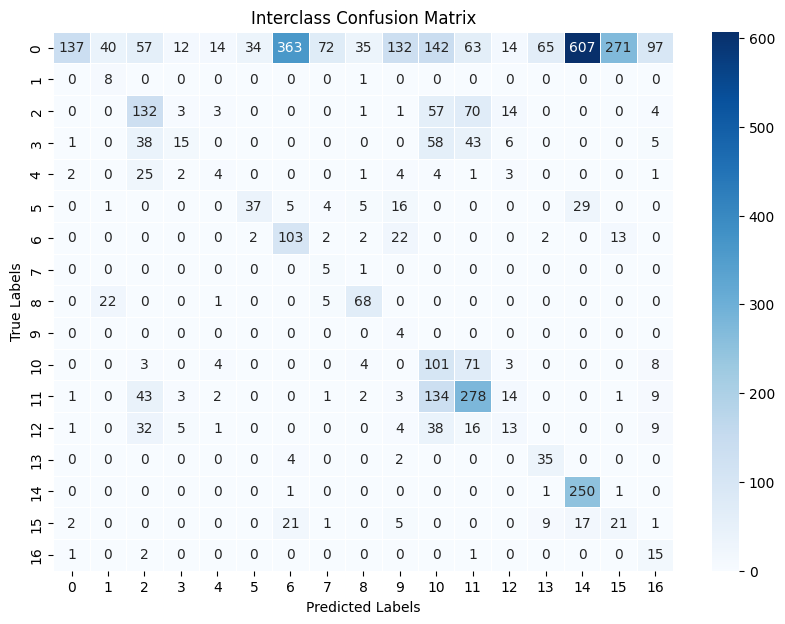

Average Interclass Distance in Latent Space: 601.6550
Total Training Time: 0.06 minutes
Kappa Coefficient: 0.2425
Adjusted Rand Index: 0.1049
✅ Class-wise Accuracy saved at: /content/drive/MyDrive/IP_XGB_Classwise_Accuracy.csv


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist

# Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)

# Load Ground Truth Data
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -1].values  # Last column as true class labels

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split Data for Training and Testing (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train XGBoost Model
xgb_classifier = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y)),  # Number of classes
    eval_metric="mlogloss",
    use_label_encoder=False,
    tree_method="gpu_hist",
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1
)

print("Training XGBoost model...")
start_time = time.time()  # Start timing
xgb_classifier.fit(X_train, y_train)
training_time = (time.time() - start_time) / 60  # Convert seconds to minutes
print(f"Training Time: {training_time:.2f} minutes")

# Extract Features from the Trained XGBoost Model
X_train_embeddings = xgb_classifier.apply(X_train)
X_test_embeddings = xgb_classifier.apply(X_test)

# Compute Class Prototypes (Mean Embeddings for Each Class)
class_prototypes = {}
for cls in np.unique(y_train):
    class_indices = np.where(y_train == cls)[0]
    class_prototypes[cls] = X_train_embeddings[class_indices].mean(axis=0)

# Convert to NumPy Array for Distance Calculation
prototype_array = np.array([class_prototypes[cls] for cls in np.unique(y_train)])

# Function to Classify Using Nearest Prototype
def classify_using_prototypes(test_embeddings):
    distances = cdist(test_embeddings, prototype_array, metric='euclidean')
    predictions = np.argmin(distances, axis=1)  # Closest prototype class
    return predictions

# Predict Using Inter-Class Classification
y_pred_inter_class = classify_using_prototypes(X_test_embeddings)

# Evaluate Accuracy
accuracy = accuracy_score(y_test, y_pred_inter_class)
print(f"Inter-Class Classification Accuracy with XGBoost: {accuracy:.4f}")

# Detailed Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_inter_class))

# 1. Interclass Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_inter_class)

# Plot Confusion Matrix with Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5, xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Interclass Confusion Matrix")
plt.show()

# 2. Feature Representation Quality (Average Interclass Distance in Latent Space)
interclass_distances = []
for i in range(len(prototype_array)):
    for j in range(i + 1, len(prototype_array)):
        dist = np.linalg.norm(prototype_array[i] - prototype_array[j])
        interclass_distances.append(dist)

avg_interclass_distance = np.mean(interclass_distances)
print(f"Average Interclass Distance in Latent Space: {avg_interclass_distance:.4f}")

# 3. Computational Efficiency (Training Time in Minutes)
print(f"Total Training Time: {training_time:.2f} minutes")

# 4. Kappa Coefficient
kappa = cohen_kappa_score(y_test, y_pred_inter_class)
print(f"Kappa Coefficient: {kappa:.4f}")

# 5. Adjusted Rand Index
ari = adjusted_rand_score(y_test, y_pred_inter_class)
print(f"Adjusted Rand Index: {ari:.4f}")

# ✅ Compute Class-wise Accuracy
unique_classes = np.unique(y_test)
classwise_accuracies = {}

for cls in unique_classes:
    cls_indices = np.where(y_test == cls)[0]
    cls_accuracy = accuracy_score(y_test[cls_indices], y_pred_inter_class[cls_indices])
    classwise_accuracies[cls] = cls_accuracy

# ✅ Save Class-wise Accuracy to CSV
classwise_accuracy_df = pd.DataFrame(list(classwise_accuracies.items()), columns=["Class", "Accuracy"])
classwise_accuracy_path = "/content/drive/MyDrive/IP_XGB_Classwise_Accuracy.csv"
classwise_accuracy_df.to_csv(classwise_accuracy_path, index=False)

print(f"✅ Class-wise Accuracy saved at: {classwise_accuracy_path}")

ADA BOOST

Training AdaBoost model...


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Training Time: 1.28 minutes
Inter-Class Classification Accuracy with AdaBoost: 0.2321
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.03      0.05      2155
           1       0.02      0.11      0.04         9
           2       0.37      0.47      0.41       285
           3       0.13      0.10      0.11       166
           4       0.12      0.13      0.12        47
           5       0.03      0.01      0.02        97
           6       0.18      0.64      0.28       146
           7       0.04      0.83      0.08         6
           8       0.18      0.21      0.20        96
           9       0.01      0.50      0.01         4
          10       0.16      0.53      0.25       194
          11       0.57      0.49      0.53       491
          12       0.00      0.00      0.00       119
          13       0.17      0.83      0.28        41
          14       0.27      0.96      0.42       253
          15       0.06   

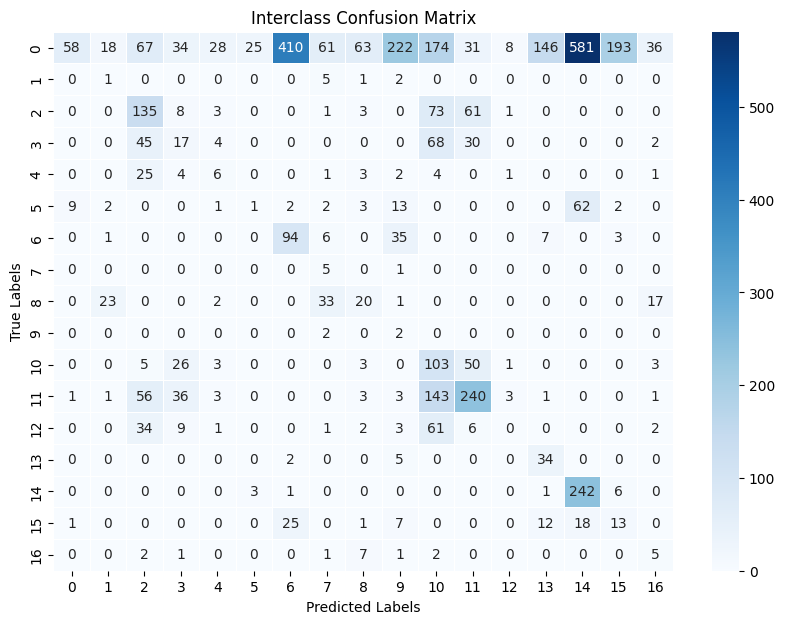

Average Interclass Distance in Latent Space: 38.5557
Total Training Time: 1.28 minutes
Kappa Coefficient: 0.1882
Adjusted Rand Index: 0.0938
✅ Class-wise Accuracy saved at: /content/drive/MyDrive/IP_AdaB_Classwise_Accuracy.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist

# Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)

# Load Ground Truth Data
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -1].values  # Last column as true class labels

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split Data for Training and Testing (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train AdaBoost Model (Using Decision Trees as Base Estimators)
adaboost_classifier = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),  # Weak learner
    n_estimators=100,  # Number of weak classifiers
    learning_rate=0.1,
    algorithm="SAMME"  # Suitable for multi-class classification
)

print("Training AdaBoost model...")
start_time = time.time()  # Start timing
adaboost_classifier.fit(X_train, y_train)
training_time = (time.time() - start_time) / 60  # Convert seconds to minutes
print(f"Training Time: {training_time:.2f} minutes")

# Extract Features from the Trained AdaBoost Model (Leaf Indices)
X_train_embeddings = np.array([tree.apply(X_train) for tree in adaboost_classifier.estimators_]).T
X_test_embeddings = np.array([tree.apply(X_test) for tree in adaboost_classifier.estimators_]).T

# Compute Class Prototypes (Mean Embeddings for Each Class)
class_prototypes = {}
for cls in np.unique(y_train):
    class_indices = np.where(y_train == cls)[0]
    class_prototypes[cls] = X_train_embeddings[class_indices].mean(axis=0)

# Convert to NumPy Array for Distance Calculation
prototype_array = np.array([class_prototypes[cls] for cls in np.unique(y_train)])

# Function to Classify Using Nearest Prototype
def classify_using_prototypes(test_embeddings):
    distances = cdist(test_embeddings, prototype_array, metric='euclidean')
    predictions = np.argmin(distances, axis=1)  # Closest prototype class
    return predictions

# Predict Using Inter-Class Classification
y_pred_inter_class = classify_using_prototypes(X_test_embeddings)

# Evaluate Accuracy
accuracy = accuracy_score(y_test, y_pred_inter_class)
print(f"Inter-Class Classification Accuracy with AdaBoost: {accuracy:.4f}")

# Detailed Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_inter_class))

# 1. Interclass Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_inter_class)

# Plot Confusion Matrix with Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5, xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Interclass Confusion Matrix")
plt.show()

# 2. Feature Representation Quality (Average Interclass Distance in Latent Space)
interclass_distances = []
for i in range(len(prototype_array)):
    for j in range(i + 1, len(prototype_array)):
        dist = np.linalg.norm(prototype_array[i] - prototype_array[j])
        interclass_distances.append(dist)

avg_interclass_distance = np.mean(interclass_distances)
print(f"Average Interclass Distance in Latent Space: {avg_interclass_distance:.4f}")

# 3. Computational Efficiency (Training Time in Minutes)
print(f"Total Training Time: {training_time:.2f} minutes")

# 4. Kappa Coefficient
kappa = cohen_kappa_score(y_test, y_pred_inter_class)
print(f"Kappa Coefficient: {kappa:.4f}")

# 5. Adjusted Rand Index
ari = adjusted_rand_score(y_test, y_pred_inter_class)
print(f"Adjusted Rand Index: {ari:.4f}")

# ✅ Compute Class-wise Accuracy
unique_classes = np.unique(y_test)
classwise_accuracies = {}

for cls in unique_classes:
    cls_indices = np.where(y_test == cls)[0]
    cls_accuracy = accuracy_score(y_test[cls_indices], y_pred_inter_class[cls_indices])
    classwise_accuracies[cls] = cls_accuracy

# ✅ Save Class-wise Accuracy to CSV
classwise_accuracy_df = pd.DataFrame(list(classwise_accuracies.items()), columns=["Class", "Accuracy"])
classwise_accuracy_path = "/content/drive/MyDrive/IP_AdaB_Classwise_Accuracy.csv"
classwise_accuracy_df.to_csv(classwise_accuracy_path, index=False)

print(f"✅ Class-wise Accuracy saved at: {classwise_accuracy_path}")

CAT BOOST

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 20.0 MB/s eta 0:00:00


Training CatBoost model...
0:	learn: 2.2220085	total: 23ms	remaining: 23s
50:	learn: 0.8367108	total: 496ms	remaining: 9.23s
100:	learn: 0.7054697	total: 936ms	remaining: 8.33s
150:	learn: 0.6279999	total: 1.37s	remaining: 7.71s
200:	learn: 0.5726934	total: 1.8s	remaining: 7.16s
250:	learn: 0.5297150	total: 2.25s	remaining: 6.71s
300:	learn: 0.4948438	total: 2.69s	remaining: 6.25s
350:	learn: 0.4644328	total: 3.13s	remaining: 5.78s
400:	learn: 0.4384006	total: 3.57s	remaining: 5.33s
450:	learn: 0.4154144	total: 4s	remaining: 4.87s
500:	learn: 0.3951338	total: 4.43s	remaining: 4.42s
550:	learn: 0.3739628	total: 4.86s	remaining: 3.96s
600:	learn: 0.3566610	total: 5.3s	remaining: 3.52s
650:	learn: 0.3404487	total: 5.74s	remaining: 3.08s
700:	learn: 0.3256420	total: 6.17s	remaining: 2.63s
750:	learn: 0.3117101	total: 6.61s	remaining: 2.19s
800:	learn: 0.2987861	total: 7.04s	remaining: 1.75s
850:	learn: 0.2857438	total: 7.49s	remaining: 1.31s
900:	learn: 0.2731399	total: 7.91s	remaining: 87

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


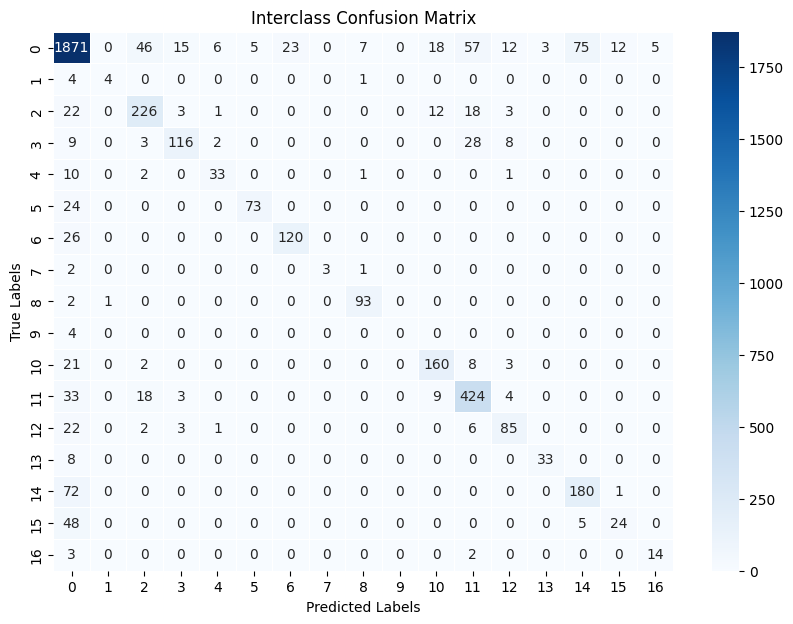

Average Interclass Distance in Latent Space: 1.0543
Total Training Time: 0.17 minutes
Kappa Coefficient: 0.7479
Adjusted Rand Index: 0.6272
✅ Class-wise Accuracy saved at: /content/drive/MyDrive/IP_CatB_Classwise_Accuracy.csv


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist

# Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)

# Load Ground Truth Data
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -1].values  # Last column as true class labels

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split Data for Training and Testing (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train CatBoost Model
catboost_classifier = CatBoostClassifier(
    iterations=1000,          # Number of boosting iterations
    depth=6,                 # Maximum depth of trees
    learning_rate=0.1,       # Learning rate
    loss_function="MultiClass",  # Multi-class classification
    eval_metric="MultiClass",
    task_type="GPU",         # Use GPU if available
    verbose=50               # Show training progress
)

print("Training CatBoost model...")
start_time = time.time()  # Start timing
catboost_classifier.fit(X_train, y_train)
training_time = (time.time() - start_time) / 60  # Convert seconds to minutes
print(f"Training Time: {training_time:.2f} minutes")

# Extract Probability-Based Features
X_train_embeddings = catboost_classifier.predict_proba(X_train)  # Probability vectors
X_test_embeddings = catboost_classifier.predict_proba(X_test)    # Probability vectors

# Compute Class Prototypes (Mean Probability Vectors for Each Class)
class_prototypes = {}
for cls in np.unique(y_train):
    class_indices = np.where(y_train == cls)[0]
    class_prototypes[cls] = X_train_embeddings[class_indices].mean(axis=0)

# Convert to NumPy Array for Distance Calculation
prototype_array = np.array([class_prototypes[cls] for cls in np.unique(y_train)])

# Function to Classify Using Nearest Prototype
def classify_using_prototypes(test_embeddings):
    distances = cdist(test_embeddings, prototype_array, metric='euclidean')
    predictions = np.argmin(distances, axis=1)  # Closest prototype class
    return predictions

# Predict Using Inter-Class Classification
y_pred_inter_class = classify_using_prototypes(X_test_embeddings)

# Evaluate Accuracy
accuracy = accuracy_score(y_test, y_pred_inter_class)
print(f"Inter-Class Classification Accuracy with CatBoost: {accuracy:.4f}")

# Detailed Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_inter_class))

# 1. Interclass Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_inter_class)

# Plot Confusion Matrix with Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5, xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Interclass Confusion Matrix")
plt.show()

# 2. Feature Representation Quality (Average Interclass Distance in Latent Space)
interclass_distances = []
for i in range(len(prototype_array)):
    for j in range(i + 1, len(prototype_array)):
        dist = np.linalg.norm(prototype_array[i] - prototype_array[j])
        interclass_distances.append(dist)

avg_interclass_distance = np.mean(interclass_distances)
print(f"Average Interclass Distance in Latent Space: {avg_interclass_distance:.4f}")

# 3. Computational Efficiency (Training Time in Minutes)
print(f"Total Training Time: {training_time:.2f} minutes")

# 4. Kappa Coefficient
kappa = cohen_kappa_score(y_test, y_pred_inter_class)
print(f"Kappa Coefficient: {kappa:.4f}")

# 5. Adjusted Rand Index
ari = adjusted_rand_score(y_test, y_pred_inter_class)
print(f"Adjusted Rand Index: {ari:.4f}")

# ✅ Compute Class-wise Accuracy
unique_classes = np.unique(y_test)
classwise_accuracies = {}

for cls in unique_classes:
    cls_indices = np.where(y_test == cls)[0]
    cls_accuracy = accuracy_score(y_test[cls_indices], y_pred_inter_class[cls_indices])
    classwise_accuracies[cls] = cls_accuracy

# ✅ Save Class-wise Accuracy to CSV
classwise_accuracy_df = pd.DataFrame(list(classwise_accuracies.items()), columns=["Class", "Accuracy"])
classwise_accuracy_path = "/content/drive/MyDrive/IP_CatB_Classwise_Accuracy.csv"
classwise_accuracy_df.to_csv(classwise_accuracy_path, index=False)

print(f"✅ Class-wise Accuracy saved at: {classwise_accuracy_path}")

# **SALINAS BOOSTING**

XG BOOST

Training XGBoost model...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 0.06 minutes


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Inter-Class Classification Accuracy with XGBoost: 0.4585
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.11      0.20      2279
           1       0.72      0.97      0.83        80
           2       0.78      0.95      0.86       149
           3       0.11      0.87      0.19        79
           4       0.27      0.98      0.42        56
           5       0.29      0.99      0.45       107
           6       0.79      0.99      0.88       158
           7       0.88      0.99      0.93       143
           8       0.64      0.59      0.61       451
           9       0.52      0.94      0.67       248
          10       0.55      0.63      0.58       131
          11       0.12      0.84      0.21        43
          12       0.30      1.00      0.47        77
          13       0.45      1.00      0.62        36
          14       0.45      0.91      0.60        43
          15       0.51      0.69      0.59       291
 

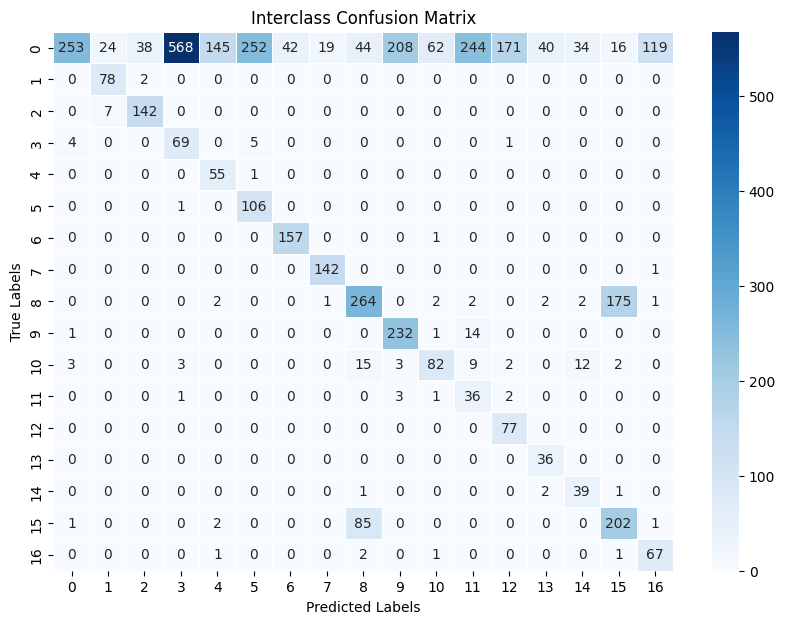

Average Interclass Distance in Latent Space: 489.6050
Total Training Time: 0.06 minutes
Kappa Coefficient: 0.4212
Adjusted Rand Index: 0.1599
✅ Class-wise Accuracy saved at: /content/drive/MyDrive/Sal_XGB_Classwise_Accuracy.csv


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist

# Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/Salinas_Reduced.csv"
df_spectral = pd.read_csv(spectral_data_path)

# Load Ground Truth Data
ground_truth_path = "/content/drive/MyDrive/Sal_sampled_gt.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -4].values  # Last column as true class labels

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split Data for Training and Testing (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train XGBoost Model
xgb_classifier = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y)),  # Number of classes
    eval_metric="mlogloss",
    use_label_encoder=False,
    tree_method="gpu_hist",
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1
)

print("Training XGBoost model...")
start_time = time.time()  # Start timing
xgb_classifier.fit(X_train, y_train)
training_time = (time.time() - start_time) / 60  # Convert seconds to minutes
print(f"Training Time: {training_time:.2f} minutes")

# Extract Features from the Trained XGBoost Model
X_train_embeddings = xgb_classifier.apply(X_train)
X_test_embeddings = xgb_classifier.apply(X_test)

# Compute Class Prototypes (Mean Embeddings for Each Class)
class_prototypes = {}
for cls in np.unique(y_train):
    class_indices = np.where(y_train == cls)[0]
    class_prototypes[cls] = X_train_embeddings[class_indices].mean(axis=0)

# Convert to NumPy Array for Distance Calculation
prototype_array = np.array([class_prototypes[cls] for cls in np.unique(y_train)])

# Function to Classify Using Nearest Prototype
def classify_using_prototypes(test_embeddings):
    from scipy.spatial.distance import cdist
    distances = cdist(test_embeddings, prototype_array, metric='euclidean')
    predictions = np.argmin(distances, axis=1)  # Closest prototype class
    return predictions

# Predict Using Inter-Class Classification
y_pred_inter_class = classify_using_prototypes(X_test_embeddings)

# Evaluate Accuracy
accuracy = accuracy_score(y_test, y_pred_inter_class)
print(f"Inter-Class Classification Accuracy with XGBoost: {accuracy:.4f}")

# Detailed Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_inter_class))

# 1. Interclass Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_inter_class)

# Plot Confusion Matrix with Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5, xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Interclass Confusion Matrix")
plt.show()

# 2. Feature Representation Quality (Average Interclass Distance in Latent Space)
interclass_distances = []
for i in range(len(prototype_array)):
    for j in range(i + 1, len(prototype_array)):
        dist = np.linalg.norm(prototype_array[i] - prototype_array[j])
        interclass_distances.append(dist)

avg_interclass_distance = np.mean(interclass_distances)
print(f"Average Interclass Distance in Latent Space: {avg_interclass_distance:.4f}")

# 3. Computational Efficiency (Training Time in Minutes)
print(f"Total Training Time: {training_time:.2f} minutes")

# 4. Kappa Coefficient
kappa = cohen_kappa_score(y_test, y_pred_inter_class)
print(f"Kappa Coefficient: {kappa:.4f}")

# 5. Adjusted Rand Index
ari = adjusted_rand_score(y_test, y_pred_inter_class)
print(f"Adjusted Rand Index: {ari:.4f}")

# ✅ Compute Class-wise Accuracy
unique_classes = np.unique(y_test)
classwise_accuracies = {}

for cls in unique_classes:
    cls_indices = np.where(y_test == cls)[0]
    cls_accuracy = accuracy_score(y_test[cls_indices], y_pred_inter_class[cls_indices])
    classwise_accuracies[cls] = cls_accuracy

# ✅ Save Class-wise Accuracy to CSV
classwise_accuracy_df = pd.DataFrame(list(classwise_accuracies.items()), columns=["Class", "Accuracy"])
classwise_accuracy_path = "/content/drive/MyDrive/Sal_XGB_Classwise_Accuracy.csv"
classwise_accuracy_df.to_csv(classwise_accuracy_path, index=False)

print(f"✅ Class-wise Accuracy saved at: {classwise_accuracy_path}")

ADA BOOST

Training AdaBoost model...


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Training Time: 1.22 minutes
Inter-Class Classification Accuracy with AdaBoost: 0.2737
Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.80      0.48      1435
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00       182
           5       0.06      0.17      0.09       333
           6       0.14      0.02      0.03       580
           7       0.00      0.00      0.00       626
           8       0.00      0.00      0.00        34
          15       0.00      0.00      0.00      1253

    accuracy                           0.27      4443
   macro avg       0.06      0.11      0.07      4443
weighted avg       0.13      0.27      0.17      4443



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

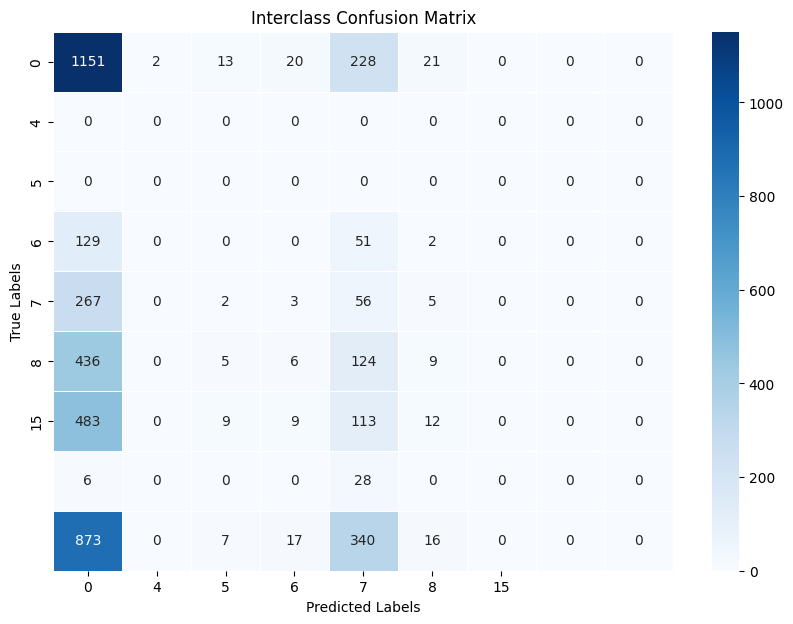

Average Interclass Distance in Latent Space: 17.0883
Total Training Time: 1.22 minutes
Kappa Coefficient: 0.0166
Adjusted Rand Index: 0.0082
✅ Class-wise Accuracy saved at: /content/drive/MyDrive/Sal_AdaB_Classwise_Accuracy.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist

# Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/Salinas_Reduced.csv"
df_spectral = pd.read_csv(spectral_data_path)

# Load Ground Truth Data
ground_truth_path = "/content/drive/MyDrive/Sal_sampled_gt.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -1].values  # Last column as true class labels

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split Data for Training and Testing (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train AdaBoost Model (Using Decision Trees as Base Estimators)
adaboost_classifier = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),  # Weak learner
    n_estimators=100,  # Number of weak classifiers
    learning_rate=0.1,
    algorithm="SAMME"  # Suitable for multi-class classification
)

print("Training AdaBoost model...")
start_time = time.time()  # Start timing
adaboost_classifier.fit(X_train, y_train)
training_time = (time.time() - start_time) / 60  # Convert seconds to minutes
print(f"Training Time: {training_time:.2f} minutes")

# Extract Features from the Trained AdaBoost Model (Leaf Indices)
X_train_embeddings = np.array([tree.apply(X_train) for tree in adaboost_classifier.estimators_]).T
X_test_embeddings = np.array([tree.apply(X_test) for tree in adaboost_classifier.estimators_]).T

# Compute Class Prototypes (Mean Embeddings for Each Class)
class_prototypes = {}
for cls in np.unique(y_train):
    class_indices = np.where(y_train == cls)[0]
    class_prototypes[cls] = X_train_embeddings[class_indices].mean(axis=0)

# Convert to NumPy Array for Distance Calculation
prototype_array = np.array([class_prototypes[cls] for cls in np.unique(y_train)])

# Function to Classify Using Nearest Prototype
def classify_using_prototypes(test_embeddings):
    distances = cdist(test_embeddings, prototype_array, metric='euclidean')
    predictions = np.argmin(distances, axis=1)  # Closest prototype class
    return predictions

# Predict Using Inter-Class Classification
y_pred_inter_class = classify_using_prototypes(X_test_embeddings)

# Evaluate Accuracy
accuracy = accuracy_score(y_test, y_pred_inter_class)
print(f"Inter-Class Classification Accuracy with AdaBoost: {accuracy:.4f}")

# Detailed Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_inter_class))

# 1. Interclass Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_inter_class)

# Plot Confusion Matrix with Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5, xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Interclass Confusion Matrix")
plt.show()

# 2. Feature Representation Quality (Average Interclass Distance in Latent Space)
interclass_distances = []
for i in range(len(prototype_array)):
    for j in range(i + 1, len(prototype_array)):
        dist = np.linalg.norm(prototype_array[i] - prototype_array[j])
        interclass_distances.append(dist)

avg_interclass_distance = np.mean(interclass_distances)
print(f"Average Interclass Distance in Latent Space: {avg_interclass_distance:.4f}")

# 3. Computational Efficiency (Training Time in Minutes)
print(f"Total Training Time: {training_time:.2f} minutes")

# 4. Kappa Coefficient
kappa = cohen_kappa_score(y_test, y_pred_inter_class)
print(f"Kappa Coefficient: {kappa:.4f}")

# 5. Adjusted Rand Index
ari = adjusted_rand_score(y_test, y_pred_inter_class)
print(f"Adjusted Rand Index: {ari:.4f}")

# ✅ Compute Class-wise Accuracy
unique_classes = np.unique(y_test)
classwise_accuracies = {}

for cls in unique_classes:
    cls_indices = np.where(y_test == cls)[0]
    cls_accuracy = accuracy_score(y_test[cls_indices], y_pred_inter_class[cls_indices])
    classwise_accuracies[cls] = cls_accuracy

# ✅ Save Class-wise Accuracy to CSV
classwise_accuracy_df = pd.DataFrame(list(classwise_accuracies.items()), columns=["Class", "Accuracy"])
classwise_accuracy_path = "/content/drive/MyDrive/Sal_AdaB_Classwise_Accuracy.csv"
classwise_accuracy_df.to_csv(classwise_accuracy_path, index=False)

print(f"✅ Class-wise Accuracy saved at: {classwise_accuracy_path}")

CAT BOOST

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 20.8 MB/s eta 0:00:00


Training CatBoost model...
0:	learn: 2.0085108	total: 15.2ms	remaining: 15.2s
50:	learn: 0.4230326	total: 561ms	remaining: 10.4s
100:	learn: 0.3447465	total: 1.08s	remaining: 9.64s
150:	learn: 0.3069078	total: 1.61s	remaining: 9.05s
200:	learn: 0.2845419	total: 2.12s	remaining: 8.44s
250:	learn: 0.2653435	total: 2.64s	remaining: 7.89s
300:	learn: 0.2514765	total: 3.16s	remaining: 7.33s
350:	learn: 0.2394128	total: 3.67s	remaining: 6.79s
400:	learn: 0.2288311	total: 4.19s	remaining: 6.25s
450:	learn: 0.2210918	total: 4.7s	remaining: 5.72s
500:	learn: 0.2129306	total: 5.21s	remaining: 5.19s
550:	learn: 0.2054780	total: 5.73s	remaining: 4.67s
600:	learn: 0.1992594	total: 6.24s	remaining: 4.14s
650:	learn: 0.1933622	total: 6.76s	remaining: 3.62s
700:	learn: 0.1877701	total: 7.28s	remaining: 3.1s
750:	learn: 0.1825624	total: 7.79s	remaining: 2.58s
800:	learn: 0.1780695	total: 8.3s	remaining: 2.06s
850:	learn: 0.1739741	total: 8.82s	remaining: 1.54s
900:	learn: 0.1695220	total: 9.33s	remaini

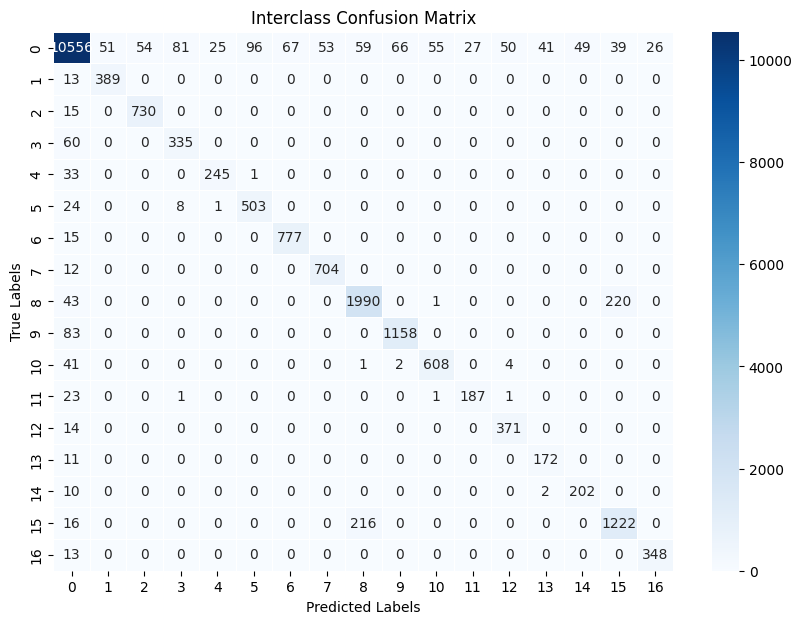

Average Interclass Distance in Latent Space: 1.2083
Total Training Time: 0.27 minutes
Kappa Coefficient: 0.8925
Adjusted Rand Index: 0.8377
✅ Class-wise Accuracy saved at: /content/drive/MyDrive/Sal_CatB_Classwise_Accuracy.csv


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist

# Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/Salinas_Dataset.csv"
df_spectral = pd.read_csv(spectral_data_path)

# Load Ground Truth Data
ground_truth_path = "/content/drive/MyDrive/Salinas_GT.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -1].values  # Last column as true class labels

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split Data for Training and Testing (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train CatBoost Model
catboost_classifier = CatBoostClassifier(
    iterations=1000,          # Number of boosting iterations
    depth=6,                 # Maximum depth of trees
    learning_rate=0.1,       # Learning rate
    loss_function="MultiClass",  # Multi-class classification
    eval_metric="MultiClass",
    task_type="GPU",         # Use GPU if available
    verbose=50               # Show training progress
)

print("Training CatBoost model...")
start_time = time.time()  # Start timing
catboost_classifier.fit(X_train, y_train)
training_time = (time.time() - start_time) / 60  # Convert seconds to minutes
print(f"Training Time: {training_time:.2f} minutes")

# Extract Probability-Based Features
X_train_embeddings = catboost_classifier.predict_proba(X_train)  # Probability vectors
X_test_embeddings = catboost_classifier.predict_proba(X_test)    # Probability vectors

# Compute Class Prototypes (Mean Probability Vectors for Each Class)
class_prototypes = {}
for cls in np.unique(y_train):
    class_indices = np.where(y_train == cls)[0]
    class_prototypes[cls] = X_train_embeddings[class_indices].mean(axis=0)

# Convert to NumPy Array for Distance Calculation
prototype_array = np.array([class_prototypes[cls] for cls in np.unique(y_train)])

# Function to Classify Using Nearest Prototype
def classify_using_prototypes(test_embeddings):
    distances = cdist(test_embeddings, prototype_array, metric='euclidean')
    predictions = np.argmin(distances, axis=1)  # Closest prototype class
    return predictions

# Predict Using Inter-Class Classification
y_pred_inter_class = classify_using_prototypes(X_test_embeddings)

# Evaluate Accuracy
accuracy = accuracy_score(y_test, y_pred_inter_class)
print(f"Inter-Class Classification Accuracy with CatBoost: {accuracy:.4f}")

# Detailed Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_inter_class))

# 1. Interclass Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_inter_class)

# Plot Confusion Matrix with Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5, xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Interclass Confusion Matrix")
plt.show()

# 2. Feature Representation Quality (Average Interclass Distance in Latent Space)
interclass_distances = []
for i in range(len(prototype_array)):
    for j in range(i + 1, len(prototype_array)):
        dist = np.linalg.norm(prototype_array[i] - prototype_array[j])
        interclass_distances.append(dist)

avg_interclass_distance = np.mean(interclass_distances)
print(f"Average Interclass Distance in Latent Space: {avg_interclass_distance:.4f}")

# 3. Computational Efficiency (Training Time in Minutes)
print(f"Total Training Time: {training_time:.2f} minutes")

# 4. Kappa Coefficient
kappa = cohen_kappa_score(y_test, y_pred_inter_class)
print(f"Kappa Coefficient: {kappa:.4f}")

# 5. Adjusted Rand Index
ari = adjusted_rand_score(y_test, y_pred_inter_class)
print(f"Adjusted Rand Index: {ari:.4f}")

# ✅ Compute Class-wise Accuracy
unique_classes = np.unique(y_test)
classwise_accuracies = {}

for cls in unique_classes:
    cls_indices = np.where(y_test == cls)[0]
    cls_accuracy = accuracy_score(y_test[cls_indices], y_pred_inter_class[cls_indices])
    classwise_accuracies[cls] = cls_accuracy

# ✅ Save Class-wise Accuracy to CSV
classwise_accuracy_df = pd.DataFrame(list(classwise_accuracies.items()), columns=["Class", "Accuracy"])
classwise_accuracy_path = "/content/drive/MyDrive/Sal_CatB_Classwise_Accuracy.csv"
classwise_accuracy_df.to_csv(classwise_accuracy_path, index=False)

print(f"✅ Class-wise Accuracy saved at: {classwise_accuracy_path}")

In [ ]:
import scipy.io
import pandas as pd
import numpy as np

# Load the Salinas hyperspectral dataset (CSV)
salinas_data_path = "/content/drive/MyDrive/Salinas_Dataset.csv"
df_spectral = pd.read_csv(salinas_data_path)

# Load the Ground Truth data (MAT file)
salinas_gt_path = "/content/drive/MyDrive/Salinas_gt.mat"
salinas_gt = scipy.io.loadmat(salinas_gt_path)

# Extract the ground truth labels (assuming the key 'salinas_gt' is present)
ground_truth_key = [key for key in salinas_gt.keys() if "gt" in key.lower()][0]
gt_array = salinas_gt[ground_truth_key]

# Flatten the ground truth labels to match the dataset format
gt_flattened = gt_array.flatten()

# Ensure the number of labels matches the dataset rows
if len(gt_flattened) == df_spectral.shape[0]:
    df_spectral["Class_Label"] = gt_flattened  # Append class labels
    # Save to CSV
    salinas_labeled_path = "/content/drive/MyDrive/Salinas_GT.csv"
    df_spectral.to_csv(salinas_labeled_path, index=False)
    output_message = f"Successfully saved labeled dataset: {salinas_labeled_path}"
else:
    output_message = f"Mismatch: Dataset rows ({df_spectral.shape[0]}) vs Labels ({len(gt_flattened)})"

output_message

'Successfully saved labeled dataset: /content/drive/MyDrive/Salinas_GT.csv'